# Matrikel-Nr: 2235021

# **House price prediction with images through neural networks**

## **Imports**

In [13]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## **Preprocessing & Exploreation**

### CSV

In [14]:
df = pd.read_csv("housing-data/socal2.csv")

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  15474 non-null  int64  
 1   street    15474 non-null  object 
 2   citi      15474 non-null  object 
 3   n_citi    15474 non-null  int64  
 4   bed       15474 non-null  int64  
 5   bath      15474 non-null  float64
 6   sqft      15474 non-null  int64  
 7   price     15474 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 967.3+ KB
None


,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


### Random shuffle data frame

In [15]:
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True) #resetting index that still shuffled when doing train-test split

shuffled_df.head()

,image_id,street,citi,n_citi,bed,bath,sqft,price
0,10598,12670 Encino Court,"Rancho Cucamonga, CA",299,4,4.1,4367,959000
1,9426,4211 Wintress Drive,"Chino, CA",79,3,2.1,1419,473800
2,9568,244 Crater Lake Drive,"Big Bear, CA",38,3,2.0,1778,519888
3,14194,202 N Las Flores Drive,"Nipomo, CA",242,4,2.1,2516,799000
4,5046,59570 Devils Ladder Road,"Mountain Center, CA",231,4,4.2,3300,1350000


### Drop Citi Column

because n_citi represents citi already

In [16]:
shuffled_df.drop(columns=['citi'], inplace=True)
shuffled_df.head(1)

,image_id,street,n_citi,bed,bath,sqft,price
0,10598,12670 Encino Court,299,4,4.1,4367,959000


### Standart Scaler on Numerical Features

In [17]:
numerical_features = ["bed", "bath", "sqft"]

scaler = StandardScaler()
shuffled_df[numerical_features] = scaler.fit_transform(shuffled_df[numerical_features])


### Label Encoder for Street Feature

gives every label a number

In [18]:
label_encoder = LabelEncoder()
shuffled_df['street'] = label_encoder.fit_transform(shuffled_df['street'])

### Show Sample Images

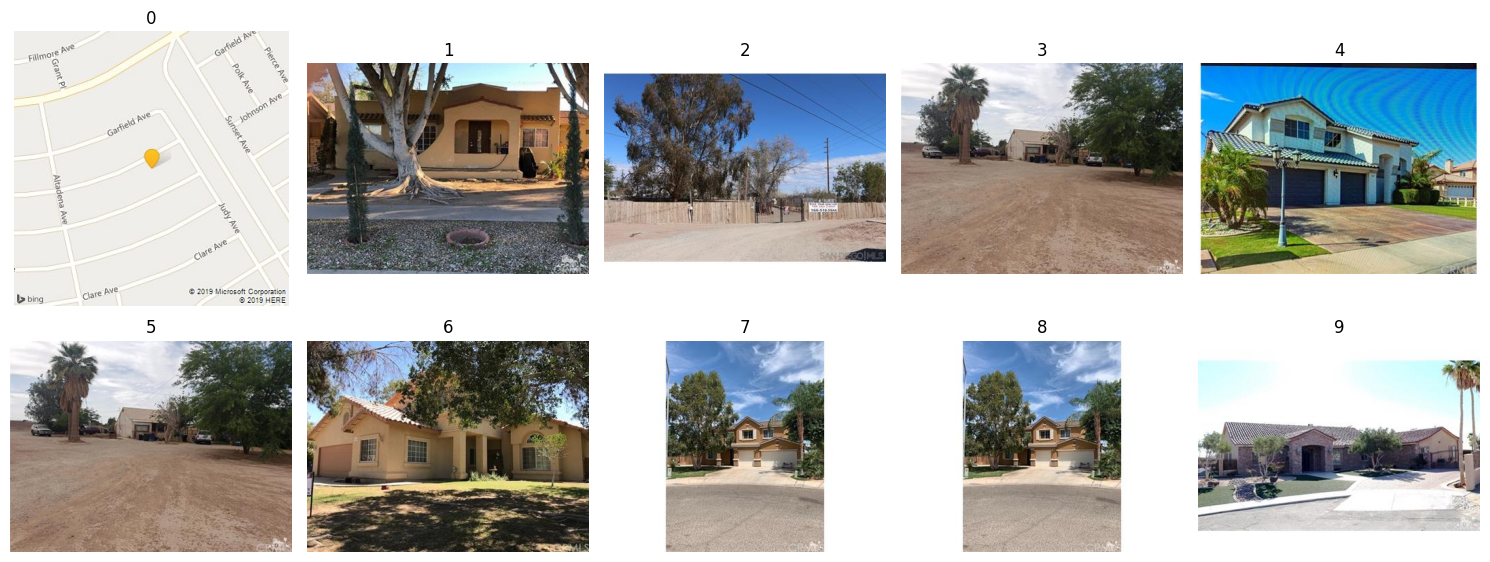

In [19]:
images_path = 'housing-data/socal2/socal_pics/'

fig, axes = plt.subplots(2, 5, figsize=(15, 6)) 
for i in range(10):
    image_path = os.path.join(images_path, f"{i}.jpg")

    img = Image.open(image_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(i)
    ax.axis('off')  
plt.tight_layout()  
plt.show() 


### Load & Transform Images To Numerical Tensors

In [20]:
"""
image_size = (100, 100)
images = []

for i in shuffled_df['image_id']:
    image_path = images_path + str(i) + '.jpg'

    img = Image.open(image_path)
    # Resize image to have all images in the same size
    img = img.resize(image_size)
    # Convert image to a numpy array as RGB
    img = np.array(img.convert('RGB')) 
    # Normalize pixel values to be in the range [0, 1] by dividing by 255 (RGB range)
    img = img / 255.0
    images.append(img)

images = np.array(images)

#print(images[200])
"""
def preprocess_images(image_id):
    img_path = os.path.join(images_path, f"{image_id}.jpg")
    img = image.load_img(img_path, target_size=(150, 350))
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Load images, resize, and preprocess
shuffled_df['image_vec'] = shuffled_df['image_id'].apply(preprocess_images)


### Remove image index column

In [21]:
shuffled_df.drop(columns=['image_id'], inplace=True)
shuffled_df.head(1)

,street,n_citi,bed,bath,sqft,price,image_vec
0,1317,299,0.477001,1.717671,2.138957,959000,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."


### Create Train - Test Data Sets

In [22]:
train_split = round(0.7 * len(df))
test_split = train_split + 1

X_train = shuffled_df.iloc[:train_split].copy()
X_test = shuffled_df.iloc[test_split:].copy()

y_train = shuffled_df['price'].iloc[:train_split]
y_test = shuffled_df['price'].iloc[test_split:]

# Drop price from X data sets
X_train.drop(columns=['price'], inplace=True)
X_test.drop(columns=['price'], inplace=True)

# Print Out The Set Sizes
print("Train: " + str(len(y_train)))
print("Test: " + str(len(y_test)))

Train: 10832
Test: 4641


In [23]:
X_train.head()

,street,n_citi,bed,bath,sqft,image_vec
0,1317,299,0.477001,1.717671,2.138957,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
1,8026,79,-0.489366,-0.368464,-0.736281,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
2,4865,38,-0.489366,-0.472771,-0.386141,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
3,3914,242,0.477001,-0.368464,0.333643,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
4,9773,231,0.477001,1.821977,1.098293,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."


In [25]:
X_train_numerical = X_train[['street', 'n_citi', 'bed', 'bath', 'sqft', ]].values
X_train_image = np.array(X_train['image_vec'].tolist())
X_train_final = X_train_image.reshape(len(X_train_image), -1)  # Flatten image array

X_test_numerical = X_test[['street', 'n_citi', 'bed', 'bath', 'sqft', ]].values
X_test_image = np.array(X_test['image_vec'].tolist())
X_test_final = X_test_image.reshape(len(X_test_image), -1)  # Flatten image array

## **Neural Network**

In [26]:
model = Sequential()

model.add(Dense(128, input_shape=(X_train_final.shape[1],), activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(32, activation='relu'))
model.add(Flatten()) 
model.add(Dense(1)) 

model.compile(
    loss='mean_absolute_error', 
    optimizer=RMSprop(learning_rate=0.001), 
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.fit(X_train_final, y_train, epochs=10, batch_size=32, validation_data=(X_test_final, y_test))


Epoch 1/10
339/339 [==============================] - 53s 152ms/step - loss: 328887.0000 - mean_absolute_error: 328887.0000 - val_loss: 277505.1250 - val_mean_absolute_error: 277505.1250
Epoch 2/10
339/339 [==============================] - 43s 126ms/step - loss: 286818.3125 - mean_absolute_error: 286818.3125 - val_loss: 274184.2812 - val_mean_absolute_error: 274184.2812
Epoch 3/10
339/339 [==============================] - 41s 121ms/step - loss: 282817.3125 - mean_absolute_error: 282817.3125 - val_loss: 270545.1875 - val_mean_absolute_error: 270545.1875
Epoch 4/10
339/339 [==============================] - 49s 144ms/step - loss: 281122.0000 - mean_absolute_error: 281122.0000 - val_loss: 269791.8438 - val_mean_absolute_error: 269791.8438
Epoch 5/10
258/339 [=====================>........] - ETA: 7s - loss: 278588.5938 - mean_absolute_error: 278588.5938

In [ ]:
y_train